In [102]:
import pandas as pd
from scipy.stats import shapiro
from scipy.stats import spearmanr
from scipy.stats import chi2_contingency
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns

In [103]:
# Processing the dataframe and dropping NaN rows
def age_category(age):
  if age < 10:
    return 0
  elif age >= 10 and age < 15:
    return 1
  elif age < 20:
    return 2
  elif age < 25:
    return 3
  elif age < 35:
    return 4
  elif age < 45:
    return 5
  elif age < 55:
    return 6
  elif age < 65:
    return 7
  elif age < 75:
    return 8
  elif age >= 75:
    return 9

age_type = pd.api.types.CategoricalDtype(categories=[0,1,2,3,4,5,6,7,8,9], ordered=True)
df = pd.read_csv("habits.data", sep=";", na_values="?")

df.kohde = pd.to_numeric(df['kohde'], errors='coerce')
df.jasen = pd.to_numeric(df['jasen'], errors='coerce')
df.pvknro = df.pvknro.map({1:'weekday', 2:'weekend'})
df.pvknro = df.pvknro.astype('category')
df.sp = df.sp.map({1:'man', 2:'woman'})
df.sp = df.sp.astype('category')
df.ASALUE = df.ASALUE.map({1:'city', 2:'municipality', 3:'rural'})
df.ASALUE = df.ASALUE.astype('category')
df.IKAL1 = df.IKAL1.apply(age_category)
df.IKAL1 = df.IKAL1.astype(age_type)
df.A1 = pd.to_numeric(df['A1'], errors='coerce')
df.A2 = pd.to_numeric(df['A2'], errors='coerce')
df.A3 = pd.to_numeric(df['A3'], errors='coerce')
df.A4 = pd.to_numeric(df['A4'], errors='coerce')
df.A5 = df.A5.map({1:'yes', 2:'no'})
df.A5 = df.A5.astype('category')
df.rename(columns={'A1': 'working', 'A2': 'sleeping', 'A3': 'reading', 'A4': 'restaurant', 'A5': 'library'}, inplace=True)
print(df.dtypes)

print(df.isnull().sum())
print(df.shape)

df = df.dropna()
print(df.shape)

kohde            int64
jasen            int64
pvknro        category
sp            category
ASALUE        category
IKAL1         category
working        float64
sleeping       float64
reading        float64
restaurant     float64
library       category
dtype: object
kohde          0
jasen          0
pvknro         0
sp             0
ASALUE         0
IKAL1          0
working       85
sleeping      88
reading       94
restaurant    91
library       62
dtype: int64
(745, 11)
(584, 11)


In [104]:
#Characterizing the individuals and activities
for col in ['pvknro', 'sp', 'ASALUE', "IKAL1", 'library']:
  print(f"\n{col}:\n", df[col].value_counts(normalize=True).round(2))

print(df[['working', 'sleeping', 'reading', 'restaurant']].describe().round(2))
print(df[['working', 'sleeping', 'reading', 'restaurant']].median().round(2))


pvknro:
 pvknro
weekday    0.51
weekend    0.49
Name: proportion, dtype: float64

sp:
 sp
woman    0.53
man      0.47
Name: proportion, dtype: float64

ASALUE:
 ASALUE
city            0.62
rural           0.21
municipality    0.17
Name: proportion, dtype: float64

IKAL1:
 IKAL1
7    0.26
6    0.23
5    0.16
4    0.14
8    0.11
9    0.07
3    0.03
0    0.00
1    0.00
2    0.00
Name: proportion, dtype: float64

library:
 library
yes    0.7
no     0.3
Name: proportion, dtype: float64
       working  sleeping  reading  restaurant
count   584.00    584.00   584.00      584.00
mean    121.52    518.42    47.48       47.95
std     207.21     98.76    63.43       58.48
min       0.00     70.00     0.00        0.00
25%       0.00    460.00     0.00        0.00
50%       0.00    510.00    30.00        0.00
75%     212.50    580.00    70.50      100.00
max     760.00    900.00   474.00      240.00
working         0.0
sleeping      510.0
reading        30.0
restaurant      0.0
dtype: float64


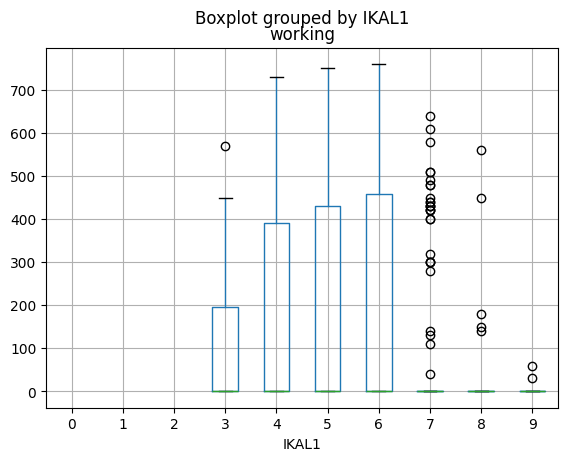

In [105]:
df.boxplot(column='working', by='IKAL1')
plt.show()

In [106]:
#The data suggests that processing the data by working people and not working people should yield better analysis results
df.loc[df['working'] >= 1, 'is_working'] = 'yes'
df.loc[df['working'] == 0, 'is_working'] = 'no'

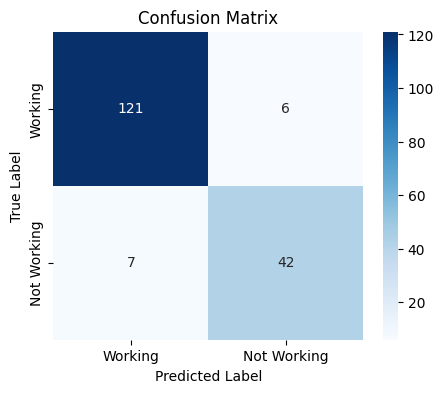

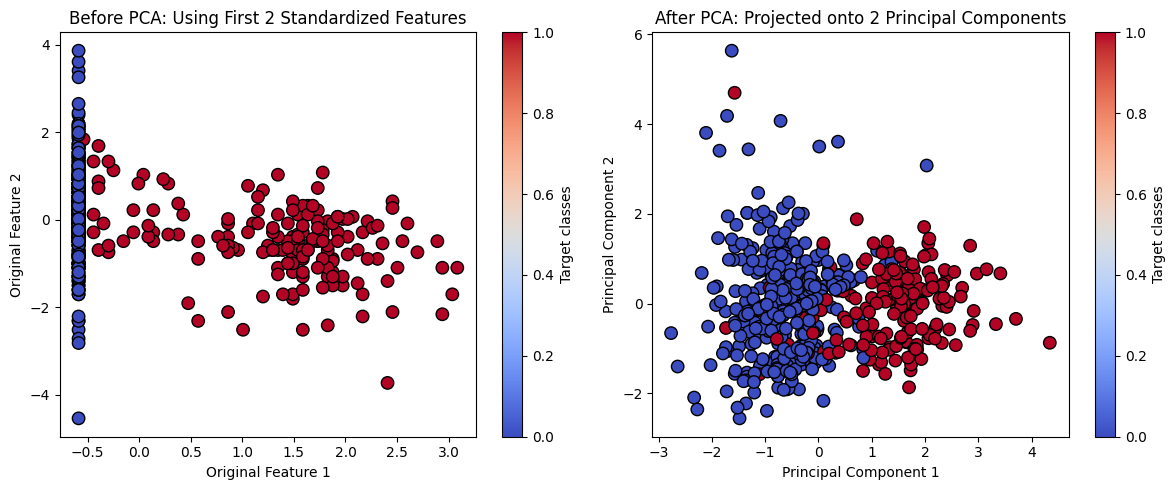

In [107]:
#PCA
columns = ['working', 'sleeping', 'reading', 'restaurant']
x = df.columns
y = df.is_working

scaler = sk.preprocessing.StandardScaler()
x_scaled = scaler.fit_transform(df[columns])

pca = sk.decomposition.PCA(n_components=2)
x_pca = pca.fit_transform(x_scaled)

x_train, x_test, y_train, y_test = sk.model_selection.train_test_split(x_pca, y, test_size=0.3, random_state=42)

model = sk.linear_model.LogisticRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

cm = sk.metrics.confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Working', 'Not Working'], yticklabels=['Working', 'Not Working'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

y_numeric = pd.factorize(y)[0]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(x_scaled[:, 0], x_scaled[:, 1], c=y_numeric, cmap='coolwarm', edgecolor='k', s=80)
plt.xlabel('Original Feature 1')
plt.ylabel('Original Feature 2')
plt.title('Before PCA: Using First 2 Standardized Features')
plt.colorbar(label='Target classes')

plt.subplot(1, 2, 2)
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=y_numeric, cmap='coolwarm', edgecolor='k', s=80)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('After PCA: Projected onto 2 Principal Components')
plt.colorbar(label='Target classes')

plt.tight_layout()
plt.show()

In [108]:
#Estimating how much time on average do Finnish household spend daily on each activity by their characterization as working or not working
print(f"Working\n {df.groupby(by=['is_working'], observed=False)['working'].mean()}")
print(f"Sleeping\n {df.groupby(by=['is_working'], observed=False)['sleeping'].mean()}")
print(f"Reading\n {df.groupby(by=['is_working'], observed=False)['reading'].mean()}")
print(f"Dining out\n{df.groupby(by=['is_working'], observed=False)['restaurant'].mean()}")
print(f"Visiting a library\n{df.groupby(by=['is_working'], observed=False)['library'].value_counts(normalize=True)}")

Working
 is_working
no       0.000000
yes    405.542857
Name: working, dtype: float64
Sleeping
 is_working
no     540.110024
yes    467.742857
Name: sleeping, dtype: float64
Reading
 is_working
no     55.960880
yes    27.651429
Name: reading, dtype: float64
Dining out
is_working
no     48.156479
yes    47.462857
Name: restaurant, dtype: float64
Visiting a library
is_working  library
no          yes        0.687042
            no         0.312958
yes         yes        0.725714
            no         0.274286
Name: proportion, dtype: float64


array([[<Axes: title={'center': 'working'}, xlabel='[ASALUE, is_working]'>,
        <Axes: title={'center': 'sleeping'}, xlabel='[ASALUE, is_working]'>],
       [<Axes: title={'center': 'reading'}, xlabel='[ASALUE, is_working]'>,
        <Axes: title={'center': 'restaurant'}, xlabel='[ASALUE, is_working]'>]],
      dtype=object)

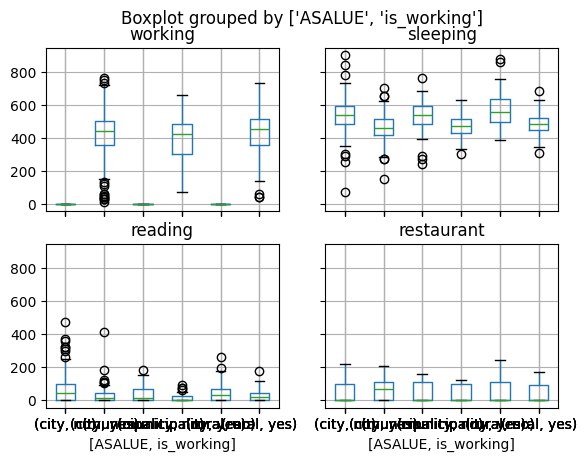

In [109]:
#With respect to which activities do living environments or days of weeks differ in Finland?
df.boxplot(column=['working','sleeping','reading','restaurant'], by=['ASALUE', 'is_working'])

array([[<Axes: title={'center': 'working'}, xlabel='[pvknro, is_working]'>,
        <Axes: title={'center': 'sleeping'}, xlabel='[pvknro, is_working]'>],
       [<Axes: title={'center': 'reading'}, xlabel='[pvknro, is_working]'>,
        <Axes: title={'center': 'restaurant'}, xlabel='[pvknro, is_working]'>]],
      dtype=object)

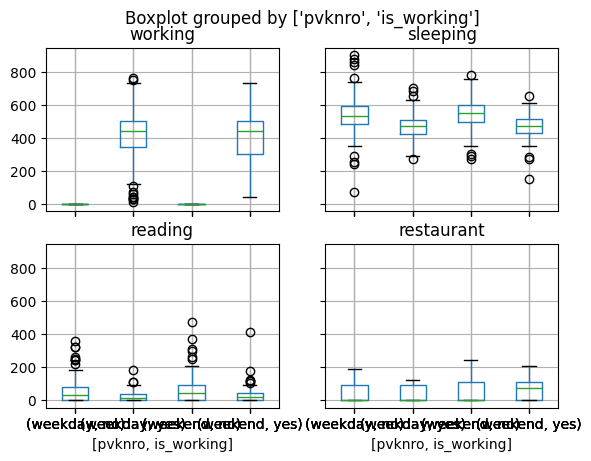

In [110]:
df.boxplot(column=['working','sleeping','reading','restaurant'], by=['pvknro', 'is_working'])

In [111]:
#Which activities are associated with each other in Finnish population
#Fist checking for normality to decide what statistical test is to be done to compare the correlation between the activities.
print(f"working\n{df.groupby(['is_working'])['working'].apply(shapiro)}")
print(f"sleeping\n{df.groupby(['is_working'])['sleeping'].apply(shapiro)}")
print(f"reading\n{df.groupby(['is_working'])['reading'].apply(shapiro)}")
print(f"eating out\n{df.groupby(['is_working'])['restaurant'].apply(shapiro)}")

working
is_working
no                                      (1.0, 1.0)
yes    (0.9363341896955203, 5.316783948128103e-07)
Name: working, dtype: object
sleeping
is_working
no     (0.9780734577939725, 7.467389704874864e-06)
yes     (0.9779259407906973, 0.006968117550411202)
Name: sleeping, dtype: object
reading
is_working
no     (0.7837201816668198, 6.756471454732433e-23)
yes    (0.6080694644446552, 8.364832588033257e-20)
Name: reading, dtype: object
eating out
is_working
no     (0.7513379283565322, 2.3974596590298836e-24)
yes     (0.7642036554511836, 1.749903683049139e-15)
Name: restaurant, dtype: object


c:\Users\mprus\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


In [112]:
#There are no normally distributed varaibles so the statistical test for correlation is a Kruskal-Wallis test
#The tests are done for every combination of the four activities
print(spearmanr(df.working, df.sleeping))
print(spearmanr(df.working, df.reading))
print(spearmanr(df.working, df.restaurant))
print(spearmanr(df.sleeping, df.reading))
print(spearmanr(df.sleeping, df.restaurant))
print(spearmanr(df.reading, df.restaurant))

# Library column being categorical the other columns need to be converted to categorical
# For categorical data Chi-square test is used to test correlation
df.loc[df['sleeping'] >= 1, 'is_sleeping'] = 'yes'
df.loc[df['sleeping'] == 0, 'is_sleeping'] = 'no'
df.loc[df['reading'] >= 1, 'is_reading'] = 'yes'
df.loc[df['reading'] == 0, 'is_reading'] = 'no'
df.loc[df['restaurant'] >= 1, 'gone_to_restaurant'] = 'yes'
df.loc[df['restaurant'] == 0, 'gone_to_restaurant'] = 'no'

print(chi2_contingency(pd.crosstab(df['library'], df['is_working']))[1])
print(chi2_contingency(pd.crosstab(df['library'], df['is_sleeping']))[1])
print(chi2_contingency(pd.crosstab(df['library'], df['is_reading']))[1])
print(chi2_contingency(pd.crosstab(df['library'], df['gone_to_restaurant']))[1])

SignificanceResult(statistic=np.float64(-0.39502145649079495), pvalue=np.float64(3.0068249015923696e-23))
SignificanceResult(statistic=np.float64(-0.2028027079981758), pvalue=np.float64(7.736770683189866e-07))
SignificanceResult(statistic=np.float64(0.0036386843967456417), pvalue=np.float64(0.9300796116169568))
SignificanceResult(statistic=np.float64(0.013975625604688227), pvalue=np.float64(0.736094958765012))
SignificanceResult(statistic=np.float64(0.015837821472173236), pvalue=np.float64(0.7025042517392928))
SignificanceResult(statistic=np.float64(-0.07478576723563128), pvalue=np.float64(0.07092815020113769))
0.40393041765021287
1.0
0.5188874159931665
0.7352613467787581


In [113]:
# Library column being categorical the other columns need to be converted to categorical
# For categorical data Chi-square test is used to test correlation
df.loc[df['sleeping'] >= 1, 'is_sleeping'] = 'yes'
df.loc[df['sleeping'] == 0, 'is_sleeping'] = 'no'
df.loc[df['reading'] >= 1, 'is_reading'] = 'yes'
df.loc[df['reading'] == 0, 'is_reading'] = 'no'
df.loc[df['restaurant'] >= 1, 'gone_to_restaurant'] = 'yes'
df.loc[df['restaurant'] == 0, 'gone_to_restaurant'] = 'no'

print(chi2_contingency(pd.crosstab(df['library'], df['is_working']))[1])
print(chi2_contingency(pd.crosstab(df['library'], df['is_sleeping']))[1])
print(chi2_contingency(pd.crosstab(df['library'], df['is_reading']))[1])
print(chi2_contingency(pd.crosstab(df['library'], df['gone_to_restaurant']))[1])

0.40393041765021287
1.0
0.5188874159931665
0.7352613467787581
